In [ ]:

from numba import cuda, int32
import numpy as np
import math
import time

def generateRandomMatrix(dimension):
    return np.random.randint(low=0, high=3, size=(dimension, dimension))

def cpuMatrixMultiply(X, Y):
    if len(X[0]) != len(Y):
        raise Exception('Can\'t multiply matrices with provided dimensions')

    result = np.zeros((len(X), len(Y[0])))

    for i in range(len(X)):
        for j in range(len(Y[0])):
            for k in range(len(Y)):
                result[i][j] += X[i][k] * Y[k][j]

    return result

# Основано на https://numba
TPB = 16

@cuda.jit
def matmul(A, B, C):
    """Perform square matrix multiplication of C = A * B."""
    i, j = cuda.grid(2)
    if i < C.shape[0] and j < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[i, k] * B[k, j]
        C[i, j] = tmp

def gpuMatrixMultiply(X, Y):
    result_host = np.zeros((len(X), len(Y[0])))

    # передача данных на устройство
    X_device = cuda.to_device(X)
    Y_device = cuda.to_device(Y)
    result_device = cuda.to_device(result_host)

    threadsperblock = (TPB, TPB)
    blockspergrid_x = math.ceil(result_host.shape[0] / threadsperblock[0])
    blockspergrid_y = math.ceil(result_host.shape[1] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    matmul[blockspergrid, threadsperblock](X_device, Y_device, result_device)
    #передача данных с девайса на хост
    result_host = result_device.copy_to_host()

    return result_host

if __name__ == "__main__":
    size = [100, 200, 300, 400, 500, 750, 1000, 1500, 2000]
    time_cpu = []
    time_gpu = []
    for k in size:
      s1 = 0
      s2 = 0
      for i in range (10):
        X = generateRandomMatrix(k)
        Y = generateRandomMatrix(k)

        start = time.time()
        result = X @ Y
        end = time.time()

        s1+=end - start

        start = time.time()
        result1 = gpuMatrixMultiply(X, Y)
        end = time.time()
        s2+=end - start
        print (np.array_equal(result1,result))
      time_cpu.append (s1/10)
      time_gpu.append (s2/10)
    print ("Results")
    print("CPU time - ", time_cpu)
    print("GPU time - ", time_gpu)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 49 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Results
CPU time -  [0.001536989212036133, 0.013960123062133789, 0.0902573823928833, 0.28693857192993166, 0.4464683771133423, 0.8637401103973389, 1.292684268951416, 4.320919871330261, 13.910536193847657]
GPU time -  [0.2200007438659668, 0.006819725036621094, 0.009653496742248534, 0.01691391468048096, 0.015813326835632323, 0.03072381019592285, 0.0808248519897461, 0.1983506679534912, 0.46762244701385497]


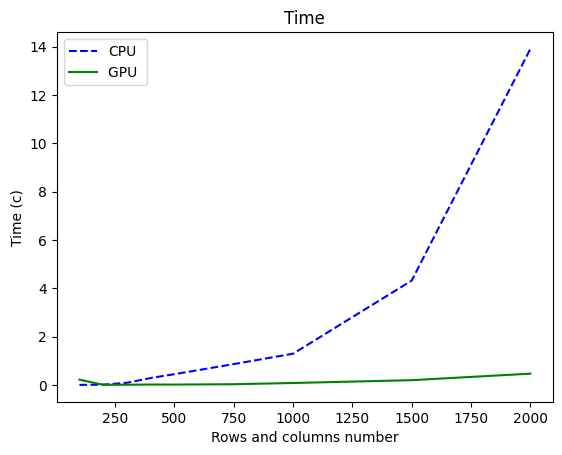

In [ ]:
import matplotlib.pyplot as plt
plt.title('Time')
plt.xlabel('Rows and columns number')
plt.ylabel('Time (c)')
plt.plot(size,time_cpu,'b--',size,time_gpu,'g')
plt.legend(['CPU','GPU '], loc=2)
plt.show()

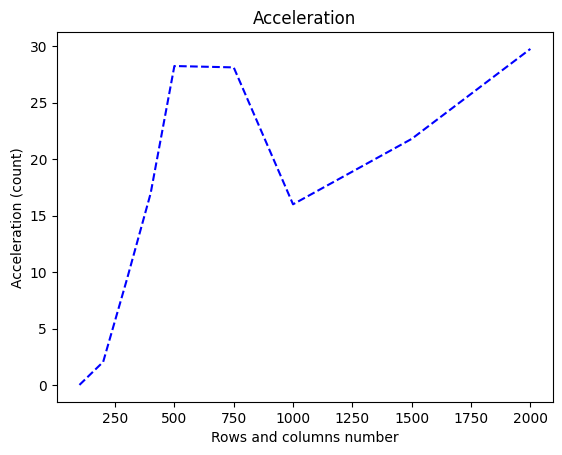

In [ ]:
plt.cla()
plt.title('Acceleration')
plt.xlabel('Rows and columns number')
plt.ylabel('Acceleration (count)')
accel = []
for i in range (len(time_cpu)):
  accel.append(time_cpu[i]/time_gpu[i])

plt.plot(size,accel,'b--')
plt.show()